# Functions - RUN THESE FIRST!

## Show Scrollable

In [21]:
from ipywidgets import HTML
from typing import Any
from IPython.display import display, HTML
from pprint import pformat


def show_scrollable(content: Any, height="300px"):
    """
    Show scrollable box in Jupyter with preserved indentation and dark theme.
    """

    if not isinstance(content, str):
        content = pformat(content)

    html = f"""
    <div style="
        height: {height};
        overflow: auto;
        background-color: black;
        color: white;
        border: 1px solid #444;
        padding: 10px;
        font-family: monospace;
        white-space: pre;  /* <— THIS PRESERVES INDENTATION */
    ">
        {content}
    </div>
    """
    display(HTML(html))

## Inspect Safe Tensors

In [43]:
from pathlib import Path
import re
from safetensors.torch import load_file
import torch
from dataclasses import dataclass


@dataclass
class QuantLayerKeys:
    base: str  # e.g., "model.layers.12.mlp.gate_proj"

    @property
    def qweight(self):
        return f"{self.base}.qweight"

    @property
    def qzeros(self):
        return f"{self.base}.qzeros"

    @property
    def scales(self):
        return f"{self.base}.scales"


def head_tensor(t: torch.Tensor, max_preview: int = 10) -> torch.Tensor:
    """
    Slice the first `max_preview` elements along every dimension.
    """
    slices = tuple(slice(0, min(dim, max_preview)) for dim in t.shape)
    return t[slices]


def natural_key(text):
    # Breaks text into chunks of digits and non-digits: "layers.10" → ["layers.", 10]
    return [int(s) if s.isdigit() else s for s in re.split(r"(\d+)", text)]


def inspect_safetensors(path: str | Path, max_preview: int = 5) -> str:
    """
    Return a readable, naturally sorted summary of a .safetensors file as a string.

    Args:
        path (str | Path): Path to the .safetensors file.
        max_preview (int): Max number of values to preview for small tensors.

    Returns:
        str: Formatted summary string.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)
    sorted_items = sorted(state_dict.items(), key=lambda x: natural_key(x[0]))

    lines = [
        f"🔍 Inspecting {path.name} — {len(sorted_items)} tensors found:",
        "",  # adds a single blank line after title
    ]

    for name, tensor in sorted_items:
        lines.append(f"- {name}: shape={tuple(tensor.shape)}, dtype={tensor.dtype}")
        if tensor.ndim <= 2 and tensor.numel() < 100:
            preview = tensor.flatten()[:max_preview].tolist()
            lines.append(f"   preview: {preview}")

    return "\n".join(lines)


def inspect_tensor(path: str | Path, tensor_name: str, max_preview: int = 10) -> str:
    """
    Inspect a specific tensor by name in a .safetensors file.

    Args:
        path (str | Path): Path to the .safetensors file.
        tensor_name (str): Exact name of the tensor to inspect.
        max_preview (int): Number of values to preview.

    Returns:
        str: Information about the tensor or a message if not found.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)

    if tensor_name not in state_dict:
        return f"❌ Tensor '{tensor_name}' not found in {path.name}"

    tensor = state_dict[tensor_name]
    info = [
        f"✅ Tensor '{tensor_name}' found in {path.name}:",
        f"   shape: {tuple(tensor.shape)}",
        f"   dtype: {tensor.dtype}",
    ]

    if tensor.ndim <= 2 and tensor.numel() > 0:
        preview = tensor.flatten()[:max_preview].tolist()
        info.append(f"   preview: {preview}")

    return "\n".join(info)


def inspect_tensor_with_preview(
    path: str | Path, tensor_name: str, max_preview: int = 10
) -> str:
    """
    Inspect a specific tensor by name in a .safetensors file.

    Args:
        path (str | Path): Path to the .safetensors file.
        tensor_name (str): Exact name of the tensor to inspect.
        max_preview (int): Number of values to preview per dimension.

    Returns:
        str: Detailed information about the tensor or a message if not found.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)

    if tensor_name not in state_dict:
        return f"❌ Tensor '{tensor_name}' not found in {path.name}"

    tensor = state_dict[tensor_name]
    info = [
        f"✅ Tensor '{tensor_name}' found in {path.name}:",
        f"   shape: {tuple(tensor.shape)}",
        f"   dtype: {tensor.dtype}",
    ]

    if tensor.numel() > 0 and (
        torch.is_floating_point(tensor)
        or tensor.dtype
        in (torch.int8, torch.int16, torch.int32, torch.int64, torch.uint8)
    ):
        info.extend(
            [
                f"   min: {tensor.min().item():.4e}",
                f"   max: {tensor.max().item():.4e}",
                f"   mean: {tensor.float().mean().item():.4e}",
            ]
        )

        preview = head_tensor(tensor, max_preview).tolist()
        info.append(f"   preview (first {max_preview} per dimension):")
        info.append(f"{preview}")

    return "\n".join(info)


def inspect_tensor_with_preview_pretty(
    path: str | Path, tensor_name: str, max_preview: int = 10
) -> str:
    """
    Inspect a specific tensor by name in a .safetensors file.

    Args:
        path (str | Path): Path to the .safetensors file.
        tensor_name (str): Exact name of the tensor to inspect.
        max_preview (int): Number of values to preview per dimension.

    Returns:
        str: Detailed information about the tensor or a message if not found.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)

    if tensor_name not in state_dict:
        return f"❌ Tensor '{tensor_name}' not found in {path.name}"

    tensor = state_dict[tensor_name]
    info = [
        f"✅ Tensor '{tensor_name}' found in {path.name}:",
        f"   shape: {tuple(tensor.shape)}",
        f"   dtype: {tensor.dtype}",
    ]

    if tensor.numel() > 0 and (
        torch.is_floating_point(tensor)
        or tensor.dtype
        in (torch.int8, torch.int16, torch.int32, torch.int64, torch.uint8)
    ):
        info.extend(
            [
                f"   min: {tensor.min().item():.4e}",
                f"   max: {tensor.max().item():.4e}",
                f"   mean: {tensor.float().mean().item():.4e}",
            ]
        )

        # Preview with newline for each top-level slice
        sliced = head_tensor(tensor, max_preview)
        if sliced.ndim >= 2:
            preview_rows = sliced[:max_preview]
            preview_str = "\n".join(str(row.tolist()) for row in preview_rows)
        else:
            preview_str = sliced[:max_preview].tolist().__str__()

        info.append(f"   preview (first {max_preview} rows/slices):\n{preview_str}")

    return "\n".join(info)


def inspect_tensor_anomalies(path: str | Path, check_nan_inf: bool = True) -> str:
    tensors = load_file(str(path))
    lines = [f"🔎 Inspecting: {path} ({len(tensors)} tensors)\n"]

    for name, tensor in tensors.items():
        shape = tuple(tensor.shape)
        dtype = str(tensor.dtype)
        msg = f"- {name}: shape={shape}, dtype={dtype}"

        try:
            t = (
                tensor.float()
                if tensor.dtype in [torch.bfloat16, torch.float16]
                else tensor
            )

            stats = []
            if check_nan_inf:
                if torch.isnan(t).any():
                    stats.append("❗ NaN")
                if torch.isinf(t).any():
                    stats.append("❗ Inf")

            if t.numel() > 0:
                if t.dtype.is_floating_point:
                    stats += [
                        f"min={t.min().item():.2e}",
                        f"max={t.max().item():.2e}",
                        f"mean={t.mean().item():.2e}",
                    ]
                elif t.dtype == torch.int32:
                    t_f = t.float()
                    stats += [
                        f"min={t.min().item():.2e}",
                        f"max={t.max().item():.2e}",
                        f"mean={t_f.mean().item():.2e}",
                    ]

            if "qzeros" in name and (t < 0).any():
                stats.append("⚠️ Negative qzero")

            if stats:
                msg += " | " + ", ".join(stats)

        except Exception as e:
            msg += f" ⚠️ Error: {e}"

        lines.append(msg)

    return "\n".join(lines)

## Plotting Funcs

### Single Plots

In [8]:
import matplotlib.pyplot as plt


def plot_tensor_distribution(
    tensor: torch.Tensor,
    title="Tensor Distribution",
    save_path=None,
):
    """
    Generic tensor visualization utility (flattened view).
    Works well for:
    - scales: float32/float16
    - zeros: int32/int16
    - clip values: float
    - Avoid using for qweight (int32 packed bit tensor)
    """
    tensor_np = tensor.detach().cpu().numpy().flatten()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(tensor_np, bins=50, color="blue", alpha=0.7)
    plt.title("Histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.plot(tensor_np, marker="o", linestyle="-", alpha=0.7)
    plt.title("Flattened Values")
    plt.xlabel("Index")
    plt.ylabel("Value")

    plt.suptitle(title)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"✅ Saved plot to: {save_path}")
    else:
        plt.show()

In [9]:
from pathlib import Path
from typing import Optional
import torch
import matplotlib.pyplot as plt
import numpy as np


def compare_plot_awq_scales(
    scales_a: torch.Tensor,
    scales_b: torch.Tensor,
    label_a: str = "Scrooge Model",
    label_b: str = "Casper Hansen Model",
    layer_name: str = "Unknown Layer",
    show_plot: bool = True,
    save_path: Optional[str | Path] = None,
):
    """
    Compare two [G, O] scale tensors for a given layer in AWQ quantized models.

    Args:
        scales_a (torch.Tensor): First model's scales (e.g., Scrooge). Shape: [G, O]
        scales_b (torch.Tensor): Second model's scales (e.g., Hansen). Shape: [G, O]
        label_a (str): Label for first model (for logging/plot).
        label_b (str): Label for second model.
        layer_name (str): Name of the layer (used for plot titles).
        show_plot (bool): If True, will display matplotlib diff heatmap.
        save_path (str or Path, optional): If provided, saves the diff heatmap to this path.

    Returns:
        dict: Summary statistics and delta tensor.
    """
    assert (
        scales_a.shape == scales_b.shape
    ), f"Shape mismatch: {scales_a.shape} vs {scales_b.shape}"
    delta = scales_a - scales_b.abs()
    mean_diff = delta.mean().item()
    max_diff = delta.max().item()
    std_diff = delta.std().item()

    print(
        f"[{layer_name}] Δ scale ({label_a} - {label_b}): mean={mean_diff:.6f}, std={std_diff:.6f}, max={max_diff:.6f}"
    )

    if show_plot or save_path:
        plt.figure(figsize=(10, 5))
        plt.imshow(delta.cpu().numpy(), cmap="coolwarm", aspect="auto")
        plt.colorbar()
        plt.title(f"[{layer_name}] |Δ Scales| ({label_a} - {label_b})")
        plt.xlabel("Output Channels (O)")
        plt.ylabel("Group (G)")
        plt.tight_layout()

        if save_path:
            save_path = Path(save_path)
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=300)
            print(f"Saved Δ scale heatmap for {layer_name} to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    return {
        "mean_diff": mean_diff,
        "std_diff": std_diff,
        "max_diff": max_diff,
        "delta": delta,
    }

In [82]:
import torch
import matplotlib.pyplot as plt


def plot_scales_per_group(
    scales: torch.Tensor,
    title: str = "Per-Group Quantization Scales",
    group_labels: Optional[list[str]] = None,
):
    """
    Plot the quantization scale for each group.

    Args:
        scales (Tensor): 1D or 2D tensor of shape [num_groups] or [G, O] where G is group count.
        title (str): Title for the plot.
        group_labels (List[str], optional): Custom x-axis labels for each group.
    """
    scales = scales.detach().cpu().float()

    if scales.ndim == 2:
        # Collapse across output channels if needed
        # [G, O] → per-group average scale
        scales = scales.mean(dim=1)

    num_groups = scales.numel()

    plt.figure(figsize=(8, 4))
    plt.plot(range(num_groups), scales, marker="o", linewidth=1.5)
    plt.title(title, fontsize=12)
    plt.xlabel("Group Index")
    plt.xticks(ticks=range(num_groups))  # label every group index
    plt.ylabel("Scale")
    if group_labels:
        plt.xticks(ticks=range(len(group_labels)), labels=group_labels, rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Multiple Plots

In [90]:
import torch
import matplotlib.pyplot as plt
from torch import Tensor


def plot_scale_per_group_histogram(
    scales: Tensor,
    label: str = "",
    max_groups: int = 20,
):
    """
    Plot histograms of per-group scales from AWQ-style [G, O] tensor.

    Args:
        scales (Tensor): [G, O] AWQ format.
        label (str): Optional label for plot title (e.g., layer name).
        max_groups (int): Max number of groups to show.
    """
    if scales.ndim != 2:
        raise ValueError(f"Expected [G, O] shape, got {scales.shape}")

    G, O = scales.shape
    max_groups = min(max_groups, G)

    fig_rows = (max_groups + 1) // 2
    fig, axes = plt.subplots(fig_rows, 2, figsize=(10, 3 * fig_rows))
    fig.suptitle(f"Scale Histograms - {label}", y=1.02)

    axes = axes.flatten() if fig_rows > 1 else axes.reshape(-1)

    for g in range(max_groups):
        group_scales = scales[g, :].detach().cpu().to(torch.float32).numpy()
        ax = axes[g]
        ax.hist(group_scales, bins=50, log=True)
        ax.set_title(f"Group {g}", fontsize=10)
        ax.set_xlabel("Scale Value", fontsize=8)
        ax.set_ylabel("Log Frequency", fontsize=8)
        ax.grid(True)

    for g in range(max_groups, len(axes)):
        axes[g].axis("off")

    plt.tight_layout()
    plt.show()

# Inspect Qwen3-4B-AWQ Model

In [10]:
# from huggingface_hub import snapshot_download
# from pathlib import Path

# model_name = "Qwen3-4B-AWQ"
# local_dir = Path("~/models/models--Qwen--Qwen3-4B-AWQ").expanduser()

# snapshot_download(repo_id=model_name, local_dir=str(local_dir))

## Safetensors File Paths - Run This First!

In [52]:
from pathlib import Path

model_name = "Qwen3-4B-AWQ Model"

snapshot_path = Path(
    "/home/xzhang/.cache/huggingface/hub/models--Qwen--Qwen3-4B-AWQ/snapshots/74d4bd2bd4bff9cafc9345221320bffb08b406a3"
)
tensor_file = str(snapshot_path / "model.safetensors")

# tensor_info = inspect_tensor_anomalies(tensor_data)
# show_scrollable(tensor_info, height="700px")

## Shapes of All Layers

In [70]:
from safetensors import safe_open

tensor_data = load_file(tensor_file)

layer_lines = []

header = f"{'Layer Name'.center(30)}" f"{'Shape'.center(30)}" f"{'Dtype'.center(30)}"
layer_lines.append(header)
layer_lines.append("_" * 100)
with safe_open(tensor_file, framework="pt") as f:
    for name in f.keys():
        tensor = f.get_tensor(name)
        layer_lines.append(
            f"{name.ljust(50)}{str(tuple(tensor.shape)).ljust(30)}{str(tensor.dtype).ljust(20)}"
        )
num_layers = len(layer_lines) - 2
summary = "\n".join(layer_lines)

print(model_name)
print(f"Number of layers: {num_layers}")
show_scrollable(summary, "500px")

Qwen3-4B-AWQ Model
Number of layers: 902


## Inspect Qweights, Zeros, and Scales

In [44]:
layer_name = "model.layers.0.mlp.down_proj"
layer_keys = QuantLayerKeys(layer_name)

print("q weights")
print(inspect_tensor_with_preview(tensor_file, layer_keys.qweight, max_preview=5))

print("\nscales")
print(inspect_tensor_with_preview(tensor_file, layer_keys.scales, max_preview=5))

print("\nzero points")
print(inspect_tensor_with_preview(tensor_file, layer_keys.qzeros, max_preview=5))

# zero_ratio = (qzeros == 0).float().mean().item()

q weights
✅ Tensor 'model.layers.0.mlp.down_proj.qweight' found in model.safetensors:
   shape: (9728, 320)
   dtype: torch.int32
   min: -2.1474e+09
   max: 2.1475e+09
   mean: -2.8829e+07
   preview (first 5 per dimension):
[[-1430881860, -1183061912, 1675319415, -1098479203, -2055767350], [-1749501814, 2003532168, 1742370679, -1115190852, 1721129415], [-1212634998, -1754560135, 1490717286, -1130916404, 1972869593], [-793064137, -2096289290, 632559646, -1106999827, -122144279], [-1195780197, 2036111704, 702252695, -844598099, -2032698920]]

scales
✅ Tensor 'model.layers.0.mlp.down_proj.scales' found in model.safetensors:
   shape: (76, 2560)
   dtype: torch.float16
   min: 1.0128e-03
   max: 7.7881e-02
   mean: 3.9285e-03
   preview (first 5 per dimension):
[[0.05181884765625, 0.026763916015625, 0.0149078369140625, 0.039398193359375, 0.01041412353515625], [0.025970458984375, 0.00943756103515625, 0.011016845703125, 0.01160430908203125, 0.0051422119140625], [0.033477783203125, 0.008758

In [45]:
layer_name = "model.layers.12.mlp.gate_proj"
layer_keys = QuantLayerKeys(layer_name)

print("q weights")
print(inspect_tensor_with_preview(tensor_file, layer_keys.qweight, max_preview=5))

print("\nscales")
print(inspect_tensor_with_preview(tensor_file, layer_keys.scales, max_preview=5))

print("\nzero points")
print(inspect_tensor_with_preview(tensor_file, layer_keys.qzeros, max_preview=5))

# zero_ratio = (qzeros == 0).float().mean().item()

q weights
✅ Tensor 'model.layers.12.mlp.gate_proj.qweight' found in model.safetensors:
   shape: (2560, 1216)
   dtype: torch.int32
   min: -2.1475e+09
   max: 2.1475e+09
   mean: -1.7034e+07
   preview (first 5 per dimension):
[[1216964999, -2006419355, -1766307944, -1770484633, -1972861080], [1520322987, -873040295, -743905784, -245823075, 31021437], [1253722524, -1718043836, -2051251096, -1535738710, 896100441], [141789577, 930638182, -2048960375, 934851940, 2086166386], [1687500867, 309832309, 2058766458, 1183498133, -1939507085]]

scales
✅ Tensor 'model.layers.12.mlp.gate_proj.scales' found in model.safetensors:
   shape: (20, 9728)
   dtype: torch.float16
   min: 2.1477e-03
   max: 1.2476e-01
   mean: 8.8833e-03
   preview (first 5 per dimension):
[[0.0085296630859375, 0.052337646484375, 0.0765380859375, 0.056243896484375, 0.07135009765625], [0.007518768310546875, 0.0090179443359375, 0.0208282470703125, 0.034515380859375, 0.031829833984375], [0.009735107421875, 0.0068511962890625

## Check for quant and unquantized layers dim - are they flipped

In [47]:
layer_name = "model.layers.12.mlp.gate_proj.qweight"

print(inspect_tensor_with_preview(path=tensor_file, tensor_name=layer_name))

✅ Tensor 'model.layers.12.mlp.gate_proj.qweight' found in model.safetensors:
   shape: (2560, 1216)
   dtype: torch.int32
   min: -2.1475e+09
   max: 2.1475e+09
   mean: -1.7034e+07
   preview (first 10 per dimension):
[[1216964999, -2006419355, -1766307944, -1770484633, -1972861080, 967481208, -1432712295, -1767339607, 2021231253, 2006485418], [1520322987, -873040295, -743905784, -245823075, 31021437, 1191221443, -18375245, -1494171652, -112222302, 1960471789], [1253722524, -1718043836, -2051251096, -1535738710, 896100441, 928433559, -1416901482, -407200852, -1146381722, 1938406588], [141789577, 930638182, -2048960375, 934851940, 2086166386, -1614194537, -1550341574, 123758445, -1666779451, -1787322250], [1687500867, 309832309, 2058766458, 1183498133, -1939507085, 1016760424, 1638176055, 957940541, -1704148822, -2008771050], [1617991941, 41377159, 1874340459, 111906802, -855127424, 1034706521, 1087415552, 252059661, 2064658574, -1827467006], [662133109, 1466469220, -2002298713, -17369

## Inspect Scales

### Shapes & Previews

In [50]:
layer_name = "model.layers.12.mlp.gate_proj.scales"

print("\nscales")
print(inspect_tensor_with_preview_pretty(tensor_file, layer_name, max_preview=10))


scales
✅ Tensor 'model.layers.12.mlp.gate_proj.scales' found in model.safetensors:
   shape: (20, 9728)
   dtype: torch.float16
   min: 2.1477e-03
   max: 1.2476e-01
   mean: 8.8833e-03
   preview (first 10 rows/slices):
[0.0085296630859375, 0.052337646484375, 0.0765380859375, 0.056243896484375, 0.07135009765625, 0.044921875, 0.054412841796875, 0.056243896484375, 0.042266845703125, 0.124755859375]
[0.007518768310546875, 0.0090179443359375, 0.0208282470703125, 0.034515380859375, 0.031829833984375, 0.01409149169921875, 0.0167999267578125, 0.0196685791015625, 0.01354217529296875, 0.0469970703125]
[0.009735107421875, 0.0068511962890625, 0.019134521484375, 0.03985595703125, 0.028778076171875, 0.01110076904296875, 0.015167236328125, 0.020111083984375, 0.01702880859375, 0.034881591796875]
[0.0077972412109375, 0.01383209228515625, 0.0242767333984375, 0.0280609130859375, 0.0185546875, 0.0168914794921875, 0.012176513671875, 0.01081085205078125, 0.01253509521484375, 0.0283203125]
[0.007389068603

In [83]:
layer_name = "model.layers.0.self_attn.q_proj.scales"

print("\nscales")
print(inspect_tensor_with_preview_pretty(tensor_file, layer_name, max_preview=10))


scales
✅ Tensor 'model.layers.0.self_attn.q_proj.scales' found in model.safetensors:
   shape: (20, 4096)
   dtype: torch.float16
   min: 1.0481e-03
   max: 8.6731e-02
   mean: 6.1145e-03
   preview (first 10 rows/slices):
[0.0025806427001953125, 0.00649261474609375, 0.004077911376953125, 0.0030765533447265625, 0.00218963623046875, 0.004703521728515625, 0.0053558349609375, 0.0037021636962890625, 0.004444122314453125, 0.004688262939453125]
[0.0024089813232421875, 0.0034999847412109375, 0.0032138824462890625, 0.0027828216552734375, 0.0020751953125, 0.0046539306640625, 0.00548553466796875, 0.0047607421875, 0.0040283203125, 0.00438690185546875]
[0.0020351409912109375, 0.0032711029052734375, 0.0031490325927734375, 0.0026683807373046875, 0.0023517608642578125, 0.004230499267578125, 0.006626129150390625, 0.003856658935546875, 0.00450897216796875, 0.0042572021484375]
[0.0027027130126953125, 0.004688262939453125, 0.0027751922607421875, 0.002758026123046875, 0.0021648406982421875, 0.00493240356

In [88]:
layer_name = "model.layers.0.self_attn.q_proj.scales"

tensor_data = load_file(tensor_file)
tensor = tensor_data[layer_name]

tensor[0, :]

tensor([0.0026, 0.0065, 0.0041,  ..., 0.0080, 0.0073, 0.0065],
       dtype=torch.float16)

### Plot Scales

Qwen3-4B-AWQ Model:
 Layer: model.layers.0.self_attn.q_proj.scales


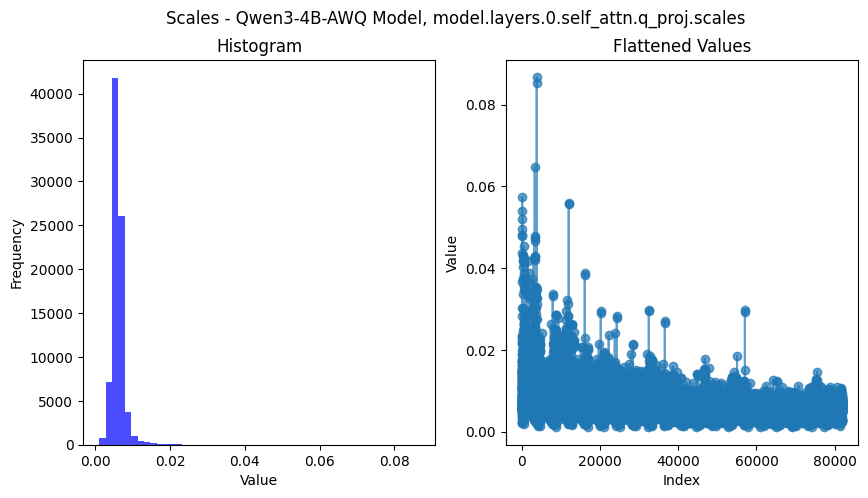

In [ ]:
from pathlib import Path
import torch
from safetensors.torch import load_file

layer_name = "model.layers.0.self_attn.q_proj.scales"

state_dict = load_file(tensor_file)
scales = state_dict[layer_name]

print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(scales, f"Scales - {model_name}, {layer_name} ")

Qwen3-4B-AWQ Model:
 Layer: model.layers.0.mlp.up_proj.scales


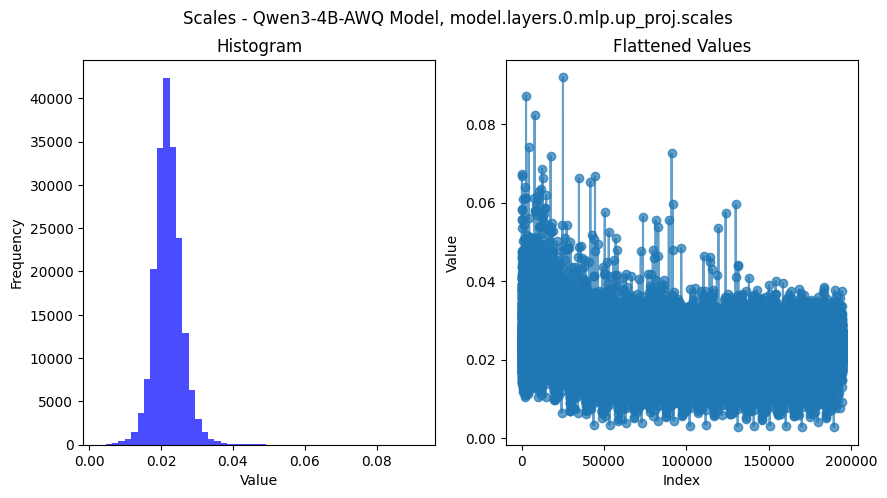

In [75]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file

layer_name = "model.layers.0.mlp.up_proj.scales"

state_dict = load_file(tensor_file)
scales = state_dict[layer_name]

print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(scales, f"Scales - {model_name}, {layer_name}")

Qwen3-4B-AWQ Model:
 Layer: model.layers.10.self_attn.q_proj.scales


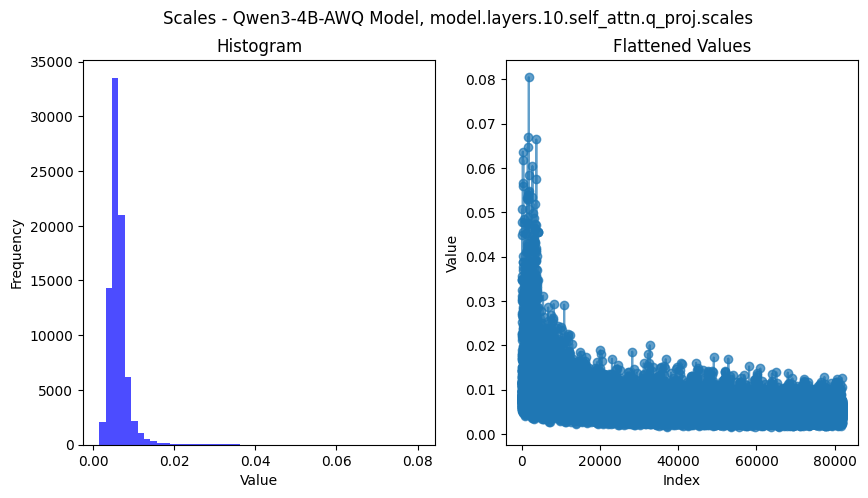

In [76]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file


layer_name = "model.layers.10.self_attn.q_proj.scales"


state_dict = load_file(tensor_file)
scales = state_dict[layer_name]


print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(scales, f"Scales - {model_name}, {layer_name}")

Qwen3-4B-AWQ Model:
 Layer: model.layers.30.self_attn.q_proj.scales


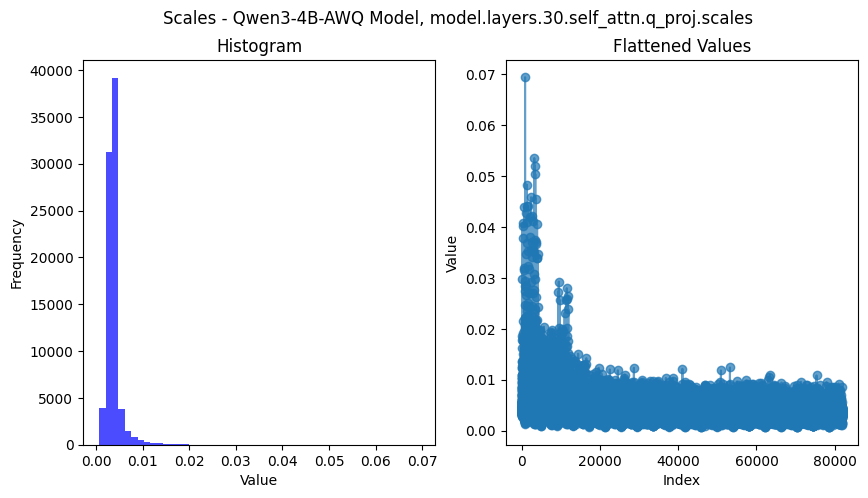

In [77]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file


layer_name = "model.layers.30.self_attn.q_proj.scales"


state_dict = load_file(tensor_file)
scales = state_dict[layer_name]


print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(scales, f"Scales - {model_name}, {layer_name}")

#### Scales Histogram Per Group

Qwen3-4B-AWQ Model:
 Layer: model.layers.0.self_attn.q_proj.scales


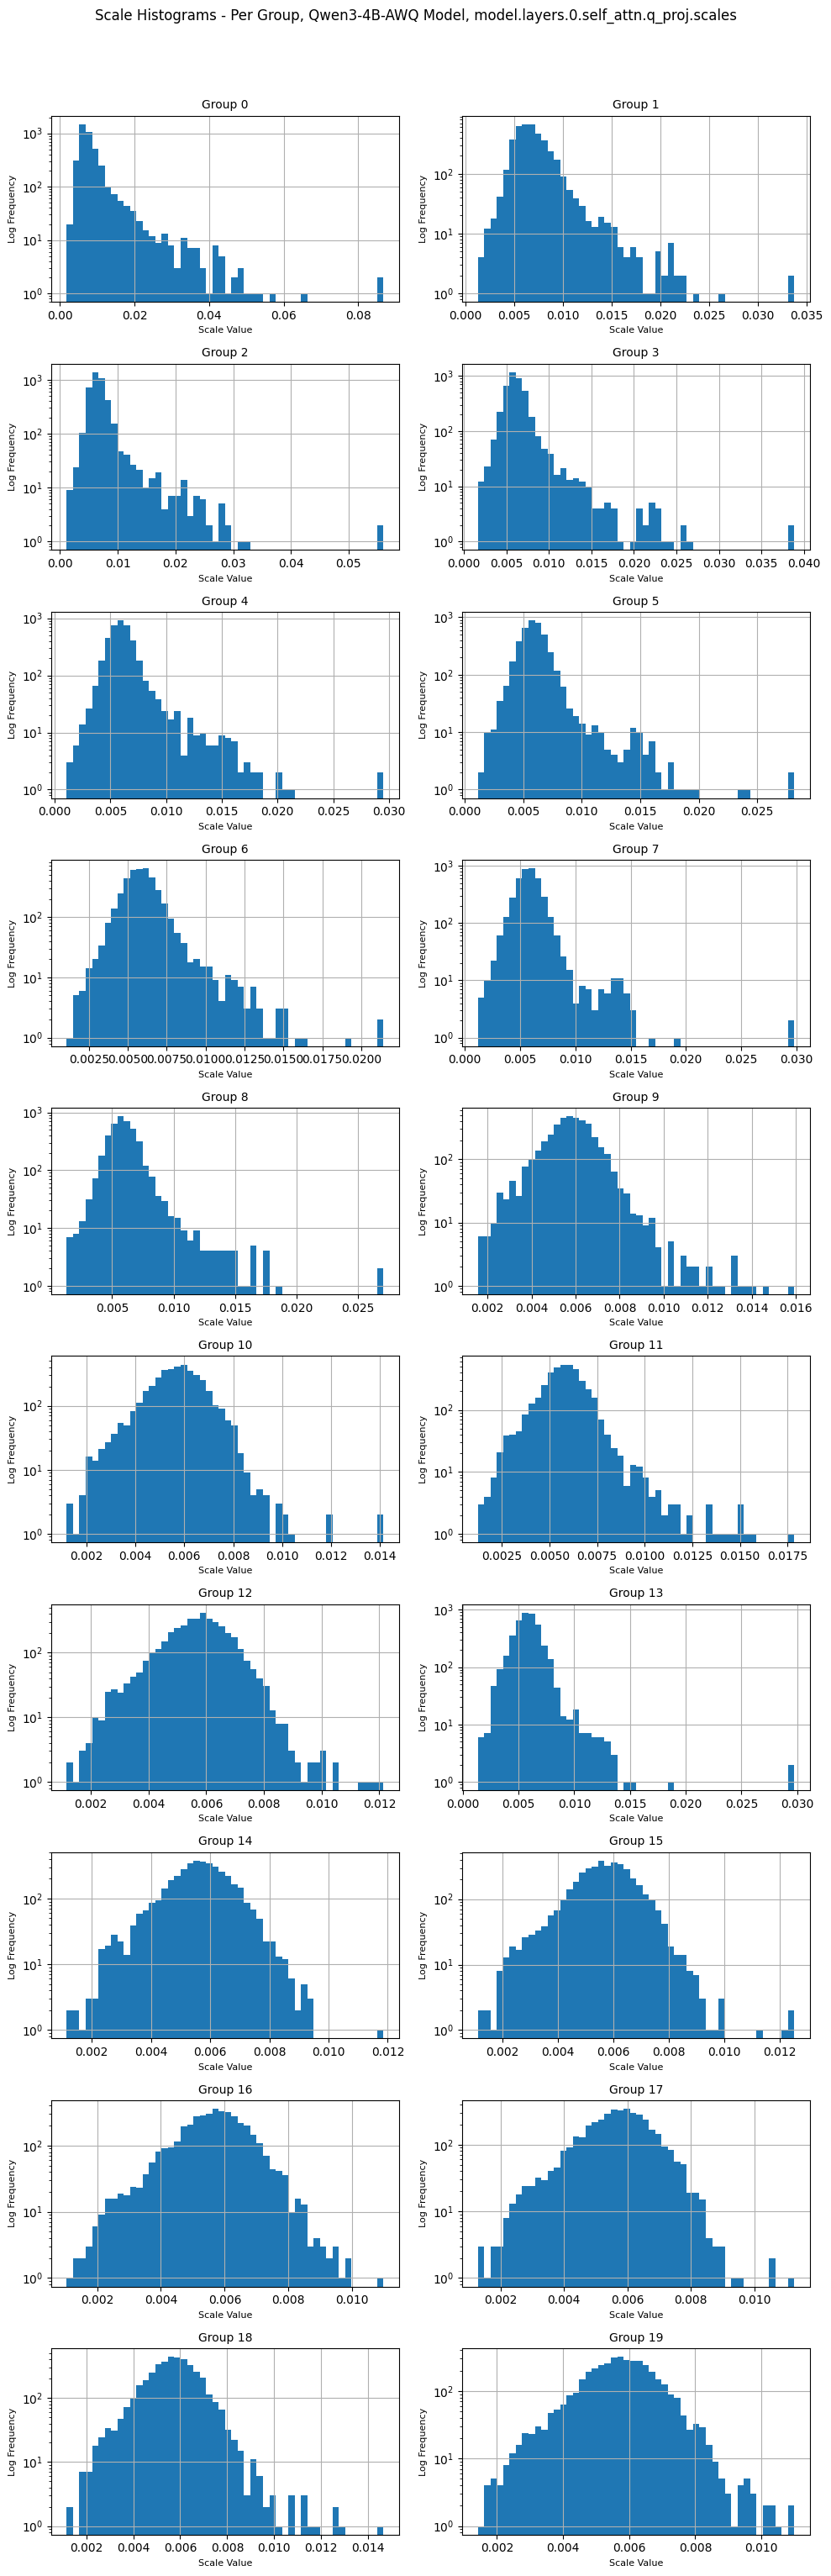

In [93]:
from pathlib import Path
import torch
from safetensors.torch import load_file

layer_name = "model.layers.0.self_attn.q_proj.scales"

state_dict = load_file(tensor_file)
scales = state_dict[layer_name]

print(f"{model_name}:\n Layer: {layer_name}")
plot_scale_per_group_histogram(
    scales, f"Per Group, {model_name}, {layer_name}", max_groups=30
)

## Inspect Zeros

In [ ]:
from pathlib import Path
import torch
from safetensors.torch import load_file

layer_name = "model.layers.0.self_attn.q_proj.qzeros"

data = load_file(tensor_file)

# Inspect available keys
print("Available keys:", data.keys())

qzeros = data["qzeros"]
print("qzeros shape:", qzeros.shape)
print("qzeros dtype:", qzeros.dtype)
print(
    "qzeros stats — min:",
    qzeros.min().item(),
    "max:",
    qzeros.max().item(),
    "mean:",
    qzeros.float().mean().item(),
)

# Percent age zero values
zero_ratio = (qzeros == 0).float().mean().item()
print(f"qzeros zero ratio: {zero_ratio:.2%}")

# Preview
print("qzeros preview:\n", qzeros[:10, :10])

### Plot Qzeros

Qwen3-4B-AWQ Model:
 Layer: model.layers.0.self_attn.q_proj.qzeros


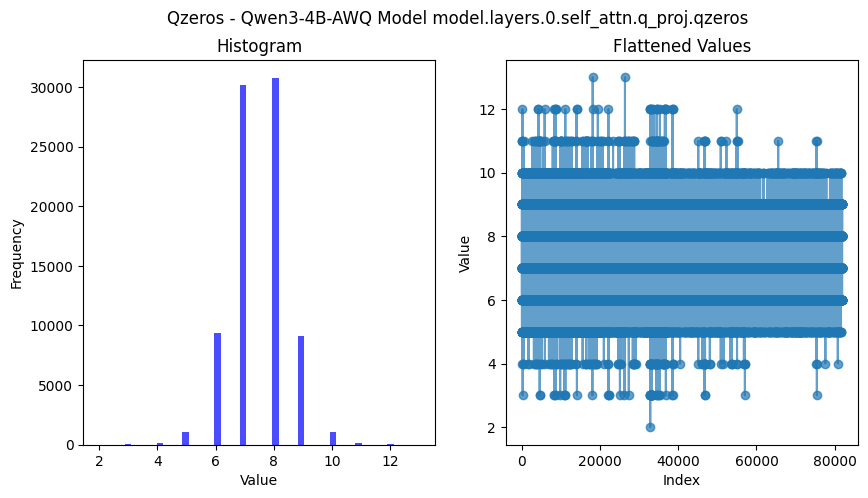

In [81]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from utils.awq_tensor_utils import unpack_qzeros_4bit_int32


layer_name = "model.layers.0.self_attn.q_proj.qzeros"

state_dict = load_file(tensor_file)
qzeros_raw = state_dict[layer_name]

qzeros = unpack_qzeros_4bit_int32(qzeros_raw)

print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(qzeros, f"Qzeros - {model_name} {layer_name}")

Qwen3-4B-AWQ Model:
 Layer: model.layers.0.self_attn.k_proj.qzeros


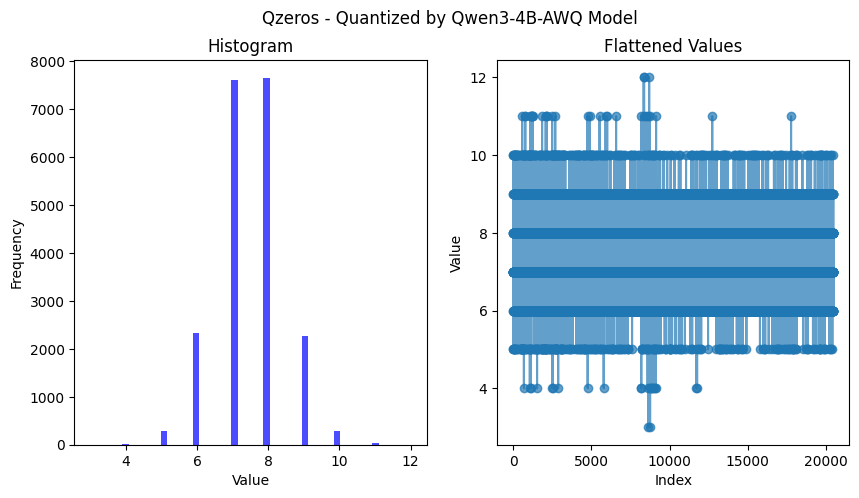

In [60]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from utils.awq_tensor_utils import unpack_qzeros_4bit_int32
from project_config import (
    DEEPSEEK_R1_DISTILL_HANSEN_QUANT_MODEL_DIR as hansen_model_dir,
)

layer_name = "model.layers.0.self_attn.k_proj.qzeros"

state_dict = load_file(tensor_file)
qzeros_raw = state_dict[layer_name]

qzeros = unpack_qzeros_4bit_int32(qzeros_raw)

print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(qzeros, f"Qzeros - Quantized by {model_name}")

Qwen3-4B-AWQ Model:
 Layer: model.layers.0.self_attn.v_proj.qzeros


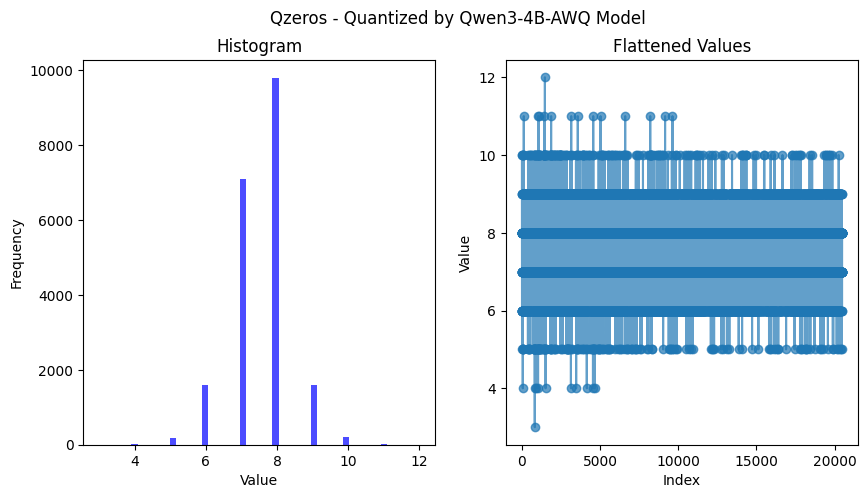

In [61]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from utils.awq_tensor_utils import unpack_qzeros_4bit_int32
from project_config import (
    DEEPSEEK_R1_DISTILL_HANSEN_QUANT_MODEL_DIR as hansen_model_dir,
)

layer_name = "model.layers.0.self_attn.v_proj.qzeros"

state_dict = load_file(tensor_file)
qzeros_raw = state_dict[layer_name]

qzeros = unpack_qzeros_4bit_int32(qzeros_raw)

print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(qzeros, f"Qzeros - Quantized by {model_name}")

Qwen3-4B-AWQ Model:
 Layer: model.layers.1.self_attn.k_proj.qzeros


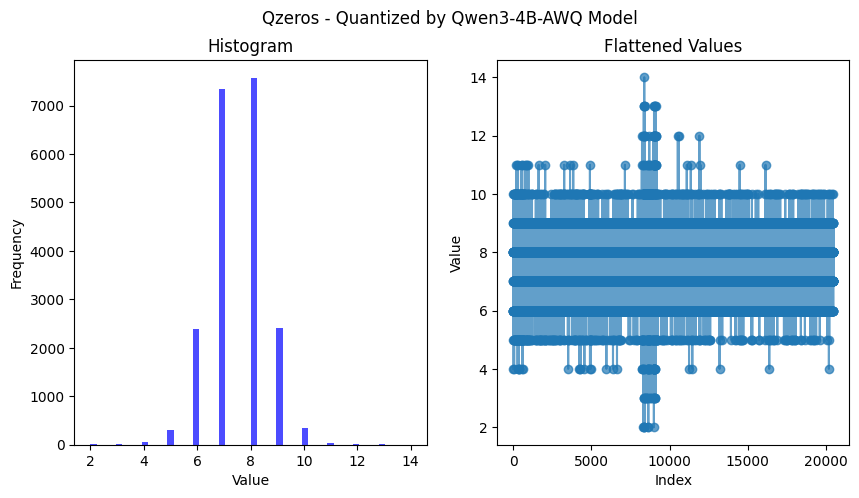

In [62]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from utils.awq_tensor_utils import unpack_qzeros_4bit_int32
from project_config import (
    DEEPSEEK_R1_DISTILL_HANSEN_QUANT_MODEL_DIR as hansen_model_dir,
)

layer_name = "model.layers.1.self_attn.k_proj.qzeros"

state_dict = load_file(tensor_file)
qzeros_raw = state_dict[layer_name]

qzeros = unpack_qzeros_4bit_int32(qzeros_raw)

print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(qzeros, f"Qzeros - Quantized by {model_name}")

## Inspect Qweight

### Plot Single Layer Qweights

Qwen3-4B-AWQ Model:
 Layer: model.layers.0.self_attn.q_proj.qweight


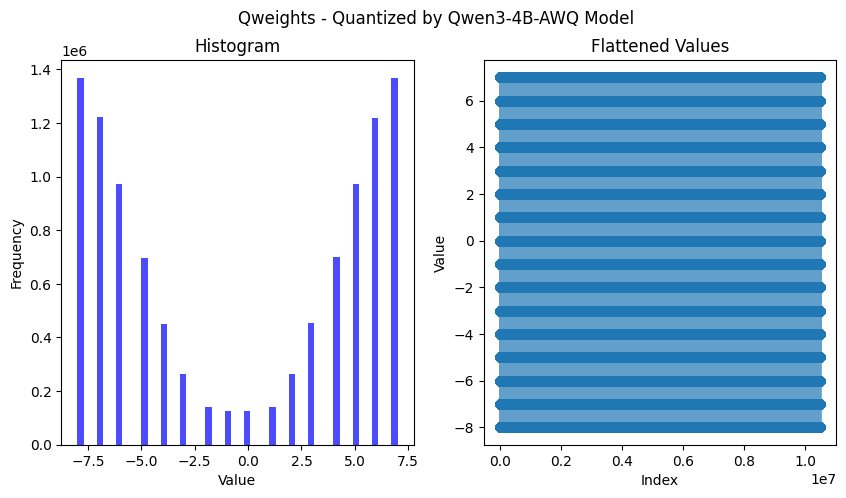

In [64]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from utils.awq_tensor_utils import unpack_qweight_4bit_int32


layer_name = "model.layers.0.self_attn.q_proj.qweight"


state_dict = load_file(tensor_file)
qweights_raw = state_dict[layer_name]

qweights = unpack_qweight_4bit_int32(qweights_raw).T.contiguous()

print(f"{model_name}:\n Layer: {layer_name}")
plot_tensor_distribution(qweights, f"Qweights - Quantized by {model_name}")

### Test Dequantized Weights

qweight shape: torch.Size([4096, 2560])
scales shape:  torch.Size([4096, 20])
qzeros shape:  torch.Size([4096, 20])
✅ Dequantized weight shape: torch.Size([4096, 2560])


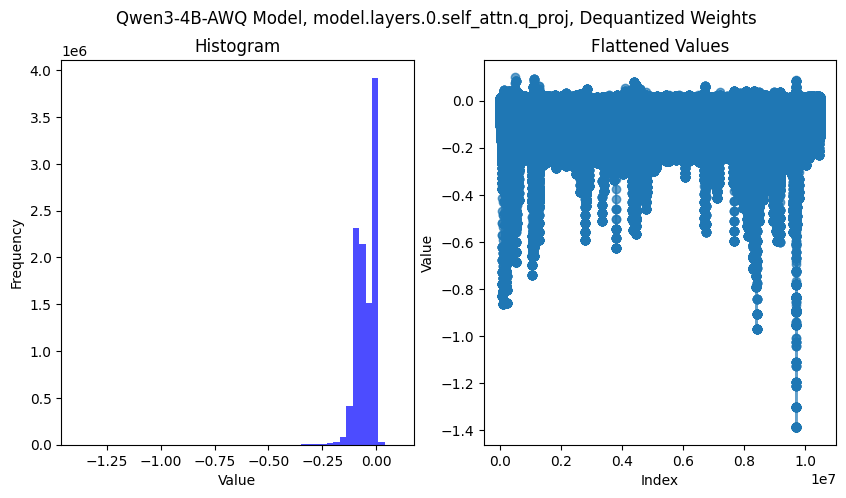

In [66]:
from utils.awq_tensor_utils import (
    load_tensor_from_safetensors,
    unpack_qweight_4bit_int32,
    unpack_qzeros_4bit_int32,
    dequantize_awq_weights,
)

layer_name = "model.layers.0.self_attn.q_proj"
layer_keys = QuantLayerKeys(layer_name)
qweight_layer = layer_keys.qweight
scales_layer = layer_keys.scales
qzeros_layer = layer_keys.qzeros

# Load quantized layer tensors
qweights_raw = load_tensor_from_safetensors(
    tensor_file, qweight_layer
)  # int32, packed int4
scales = load_tensor_from_safetensors(tensor_file, scales_layer)  # [G, O], float16
qzeros_raw = load_tensor_from_safetensors(
    tensor_file, qzeros_layer
)  # int32, packed int4
group_size = 128


# Unpack raw tensors
qweight = unpack_qweight_4bit_int32(
    qweights_raw
).T.contiguous()  # qweight is in [I, O] shape - need to transpose
qzeros = unpack_qzeros_4bit_int32(
    qzeros_raw
).T.contiguous()  # ✅ if qzeros_raw is [G, O]
scales = scales.T.contiguous()  # [O, G]

print("qweight shape:", qweight.shape)
print("scales shape: ", scales.shape)
print("qzeros shape: ", qzeros.shape)

# Dequantize to float32
w_fp32 = dequantize_awq_weights(qweight, scales, group_size, qzeros=qzeros)

print("✅ Dequantized weight shape:", w_fp32.shape)

plot_tensor_distribution(w_fp32, f"{model_name}, {layer_name}, Dequantized Weights")

qweight shape: torch.Size([4096, 2560])
scales shape:  torch.Size([4096, 20])
qzeros shape:  torch.Size([4096, 20])
✅ Dequantized weight shape: torch.Size([4096, 2560])


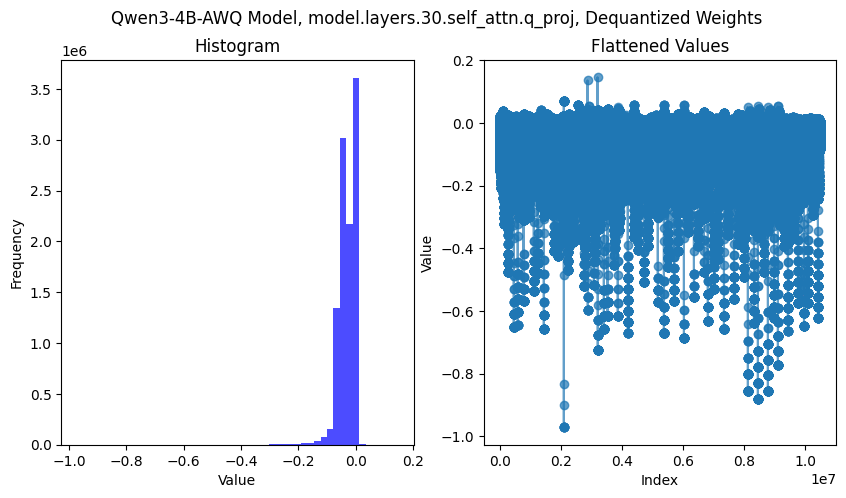

In [71]:
from utils.awq_tensor_utils import (
    load_tensor_from_safetensors,
    unpack_qweight_4bit_int32,
    unpack_qzeros_4bit_int32,
    dequantize_awq_weights,
)

layer_name = "model.layers.30.self_attn.q_proj"
layer_keys = QuantLayerKeys(layer_name)
qweight_layer = layer_keys.qweight
scales_layer = layer_keys.scales
qzeros_layer = layer_keys.qzeros

# Load quantized layer tensors
qweights_raw = load_tensor_from_safetensors(
    tensor_file, qweight_layer
)  # int32, packed int4
scales = load_tensor_from_safetensors(tensor_file, scales_layer)  # [G, O], float16
qzeros_raw = load_tensor_from_safetensors(
    tensor_file, qzeros_layer
)  # int32, packed int4
group_size = 128


# Unpack raw tensors
qweight = unpack_qweight_4bit_int32(
    qweights_raw
).T.contiguous()  # qweight is in [I, O] shape - need to transpose
qzeros = unpack_qzeros_4bit_int32(
    qzeros_raw
).T.contiguous()  # ✅ if qzeros_raw is [G, O]
scales = scales.T.contiguous()  # [O, G]

print("qweight shape:", qweight.shape)
print("scales shape: ", scales.shape)
print("qzeros shape: ", qzeros.shape)

# Dequantize to float32
w_fp32 = dequantize_awq_weights(qweight, scales, group_size, qzeros=qzeros)

print("✅ Dequantized weight shape:", w_fp32.shape)

plot_tensor_distribution(w_fp32, f"{model_name}, {layer_name}, Dequantized Weights")

In [1]:
from datetime import datetime
from pathlib import Path
import os
import logging
import time
from typing import Optional, Dict
from dotenv import load_dotenv
import psutil
from awq import AutoAWQForCausalLM
import torch
from transformers import AutoTokenizer, PreTrainedTokenizer

# From project modules
from quantize.scrooge_awq_quantizer import (
    ScroogeAwqQuantizer,
    # persist_awq_quantized_model,
)
from project_config import DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR
from utils.vram_tracker import monitor_vram, VRAMMonitor
from utils.inspect_quant_layers import inspect_quant_layer_files
import logging_config  # assuming this sets up logging globally


load_dotenv()

# Load global config variables
BASE_MODEL = os.getenv(
    "MODEL_NAME_HF"
)  # Example: deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
HF_TOKEN = os.getenv("HUGGING_FACE_TOKEN")
OUT_DIR = str(DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR)

if BASE_MODEL is None:
    raise ValueError("Environment variable MODEL_NAME_HF must be set.")

os.makedirs(OUT_DIR, exist_ok=True)


def load_model_and_tokenizer(
    base_model: str,
) -> tuple[AutoAWQForCausalLM, PreTrainedTokenizer]:
    """Load full precision model and tokenizer."""
    model = AutoAWQForCausalLM.from_pretrained(
        base_model,
        trust_remote_code=True,
        token=HF_TOKEN,
        device_map=None,  # Set this to None (manually manage)
        low_cpu_mem_usage=False,  # * Turn off meta device
    )
    tokenizer = AutoTokenizer.from_pretrained(
        base_model,
        trust_remote_code=True,
        token=HF_TOKEN,
    )
    return model, tokenizer


model, tokenizer = load_model_and_tokenizer(BASE_MODEL)
print(f"Tokenizer class: {type(tokenizer)}")
print(f"Tokenizer config class: {getattr(tokenizer, 'tokenizer_class', None)}")

INFO - ✅ Logging configured successfully (console + file + resource.log)


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

DEBUG - quantization_config dict: None

📁 Loaded quant_config from: /home/xzhang/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-1.5B/snapshots/ad9f0ae0864d7fbcd1cd905e3c6c5b069cc8b562
quant_config.config_file_name: config.json (type: <class 'str'>)
quant_config.modules_to_not_convert: None (type: <class 'NoneType'>)
quant_config.q_group_size: 128 (type: <class 'int'>)
quant_config.quant_method: awq (type: <class 'str'>)
quant_config.version: gemm (type: <class 'str'>)
quant_config.w_bit: 4 (type: <class 'int'>)
quant_config.zero_point: True (type: <class 'bool'>)
Tokenizer class: <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>
Tokenizer config class: None
